In [1]:
import numpy as np

ROWS, COLS = 6, 7

def initialize_board():
    return np.zeros((ROWS, COLS), dtype=int)

def drop_piece(board, row, col, piece):
    board[row][col] = piece

def is_valid_location(board, col):
    return board[ROWS-1][col] == 0

def is_board_full(board):
    return np.all(board[ROWS-1, :] != 0)

def get_next_open_row(board, col):
    for r in range(ROWS):
        if board[r][col] == 0:
            return r

def check_win(board, piece):
    for c in range(COLS-3):
        for r in range(ROWS):
            if np.all(board[r, c:c+4] == piece):
                return True
                
    for c in range(COLS):
        for r in range(ROWS-3):
            if np.all(board[r:r+4, c] == piece):
                return True
                
    for c in range(COLS-3):
        for r in range(ROWS-3):
            if np.all([board[r+i][c+i] == piece for i in range(4)]):
                return True
                
    for c in range(COLS-3):
        for r in range(3, ROWS):
            if np.all([board[r-i][c+i] == piece for i in range(4)]):
                return True
                
    return False

def display_board(board):
    for row in reversed(board):
        display_row = ""
        for cell in row:
            if cell == 0:
                display_row += ". "
            elif cell == 1:
                display_row += "X "
            elif cell == 2:
                display_row += "O "
        print(display_row)
    print("="*14)

In [2]:
def find_last_empty_row(board, col):
    for row in reversed(range(len(board))):
        if board[row][col] == 0:
            return row
    return -1

def reward_alignments(board, action, player):
    reward = 0
    fork_opportunities = 0
    
    row = find_last_empty_row(board, action)
    if row == -1:
        return 0
    
    opponent = 3 - player
    directions = [(0, 1), (1, 0), (1, 1), (1, -1)]
    board_height = len(board)
    board_width = len(board[0])

    for dx, dy in directions:
        player_streak = 0
        opponent_streak = 0

        for dir in [-1, 1]:
            nx, ny = row, action
            
            for _ in range(3):
                nx += dx * dir
                ny += dy * dir

                if nx < 0 or nx >= board_height or ny < 0 or ny >= board_width:
                    break

                if board[nx][ny] == player:
                    player_streak += 1
                elif board[nx][ny] == opponent:
                    opponent_streak += 1
                    break
                else:
                    break

        if player_streak >= 3:
            reward += 20  # Highly reward almost-wins
            fork_opportunities += 1
        elif player_streak == 2:
            reward += 5  # Moderately reward potential wins
        elif opponent_streak >= 3:
            reward -= 10  # Penalize opponent almost-wins
        elif opponent_streak == 2:
            reward -= 5  # Slightly penalize opponent potential wins

    if fork_opportunities > 1:
        reward += 10  # Reward fork opportunities

    if action in range(2, 5):  # If the action is towards the center
        reward += 2  # Slightly reward center placements

    return reward

def execute_action(board, action, player, current_turn):
    if not is_valid_location(board, action):
        return board, -50, True
    
    row = get_next_open_row(board, action)
    drop_piece(board, row, action, player)
    
    if check_win(board, player):
        return board, 10 * 25 / (current_turn + 1), True

    reward = reward_alignments(board, action, player) * 10 / (current_turn + 1)
    
    return board, reward, False

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.optimizers import Adam

def build_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(6, 7, 1)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

In [4]:
import numpy as np
import random

class RandomAgent:
    def select_action(self, state):
        if is_board_full(state):
            return None

        valid_actions = [i for i in range(7) if is_valid_location(state, i)]
        if valid_actions:
            return random.choice(valid_actions)
        else:
            return None

class QLearningAgent:
    def __init__(self, model, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.model = model
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.memory = []
        self.batch_size = 32

    def select_action(self, state):
        if is_board_full(state):
            return None
        elif np.random.rand() <= self.epsilon:
            return random.choice([i for i in range(7) if is_valid_location(state, i)])
        else:
            q_values = self.model.predict(state.reshape(1, 6, 7, 1), verbose=0)
            return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        states, targets_f = [], []
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + 0.99 * np.amax(self.model.predict(next_state.reshape(1, 6, 7, 1), verbose=0)[0])

            target_f = self.model.predict(state.reshape(1, 6, 7, 1), verbose=0)
            target_f[0][action] = target

            states.append(state.reshape(1, 6, 7, 1))
            targets_f.append(target_f)

        states = np.vstack(states)
        targets_f = np.vstack(targets_f)
        
        self.model.fit(states, targets_f, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [5]:
from tqdm import tqdm

def evaluate_agent(agent, random_agent, n_games=100):
    victories = 0
    n_rows, n_cols = 6, 7

    for _ in tqdm(range(n_games)):
        state = np.zeros((n_rows, n_cols), dtype=int)
        done = False
        current_player = 1
        current_turn = 0

        while not done:
            action = agent.select_action(state) if current_player == 1 else random_agent.select_action(state)

            if action is None:
                break

            next_state, reward, done = execute_action(state.copy(), action, current_player, current_turn // 2)
            state = next_state

            current_player = 3 - current_player
            current_turn += 1

        if done and reward > 0:
            victories += 1

    return victories / n_games

In [6]:
from tqdm import tqdm

class Connect4Trainer:
    def __init__(self, build_model_function, agent_class, random_agent_class):
        self.build_model = build_model_function
        self.agent_class = agent_class
        self.random_agent_class = random_agent_class

    def self_play_training(self, max_epochs=100, evals_epoch=100):
        model = self.build_model()
        agent = self.agent_class(model)
        learning_history = {"self_play": [], "turns": [], "random": []}

        for ep in tqdm(range(max_epochs)):
            state = initialize_board()
            done = False
            current_player = 1
            rewards = 0
            current_turn = 0

            while not done:
                action = agent.select_action(state)
                next_state, reward, done = execute_action(state.copy(), action, current_player, current_turn // 2)
                state = next_state
                rewards += reward
                current_turn += 1

            learning_history["self_play"].append(rewards)
            learning_history["turns"].append(current_turn // 2)

            if (ep + 1) % evals_epoch == 0:
                random_agent = self.random_agent_class()
                win_rate = evaluate_agent(agent, random_agent)
                learning_history["random"].append(round(100 * win_rate, 2))
                print(f"Epoch {ep + 1}: Win rate vs Random: {round(100 * win_rate, 2)}%")

            agent.train()

        return model, learning_history

100%|██████████| 1500/1500 [00:06<00:00, 233.25it/s]


Epoch 1500: Win rate vs Random: 100.0%


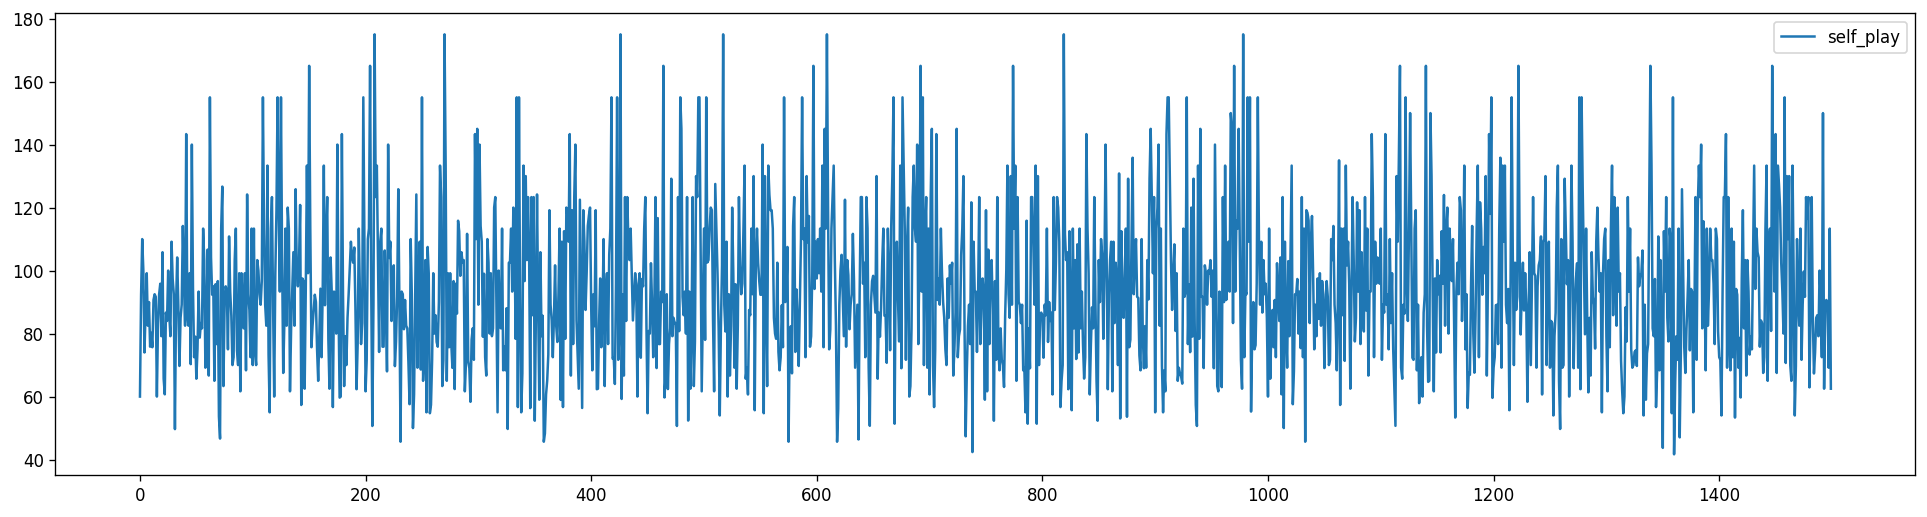

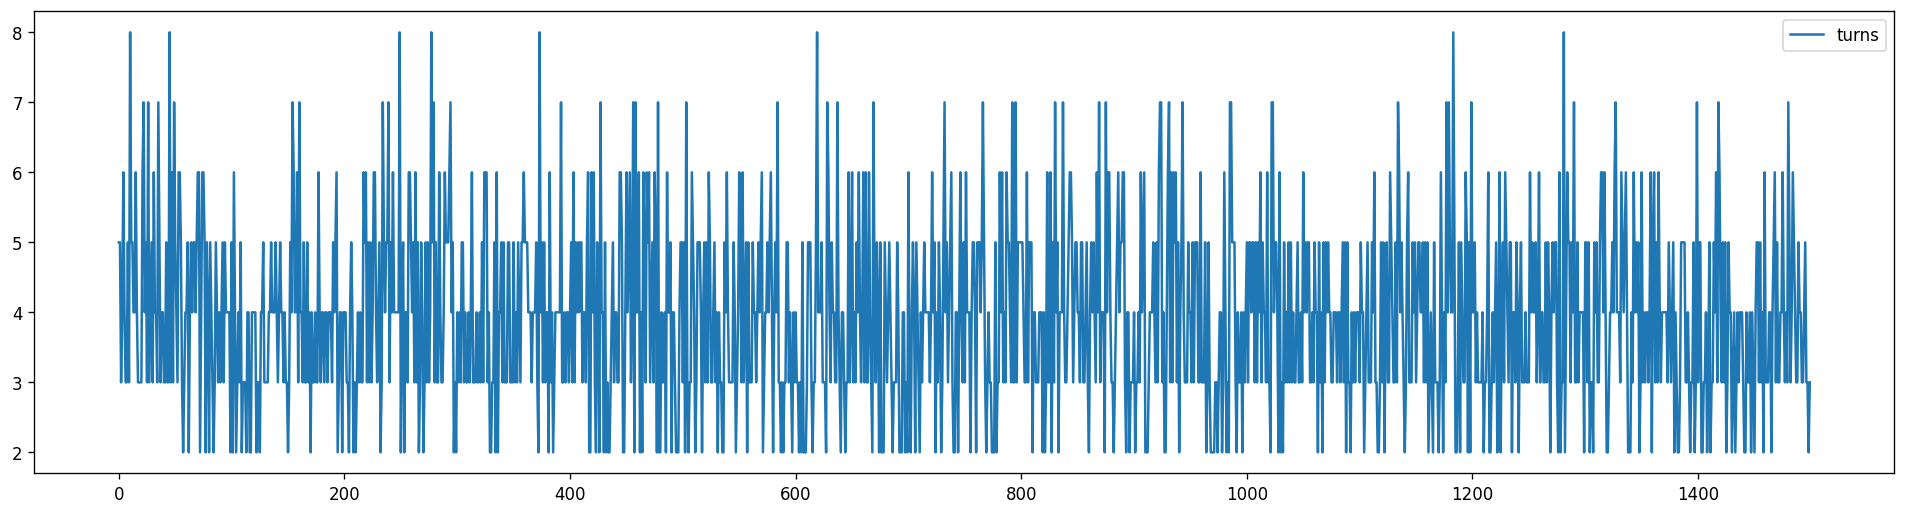

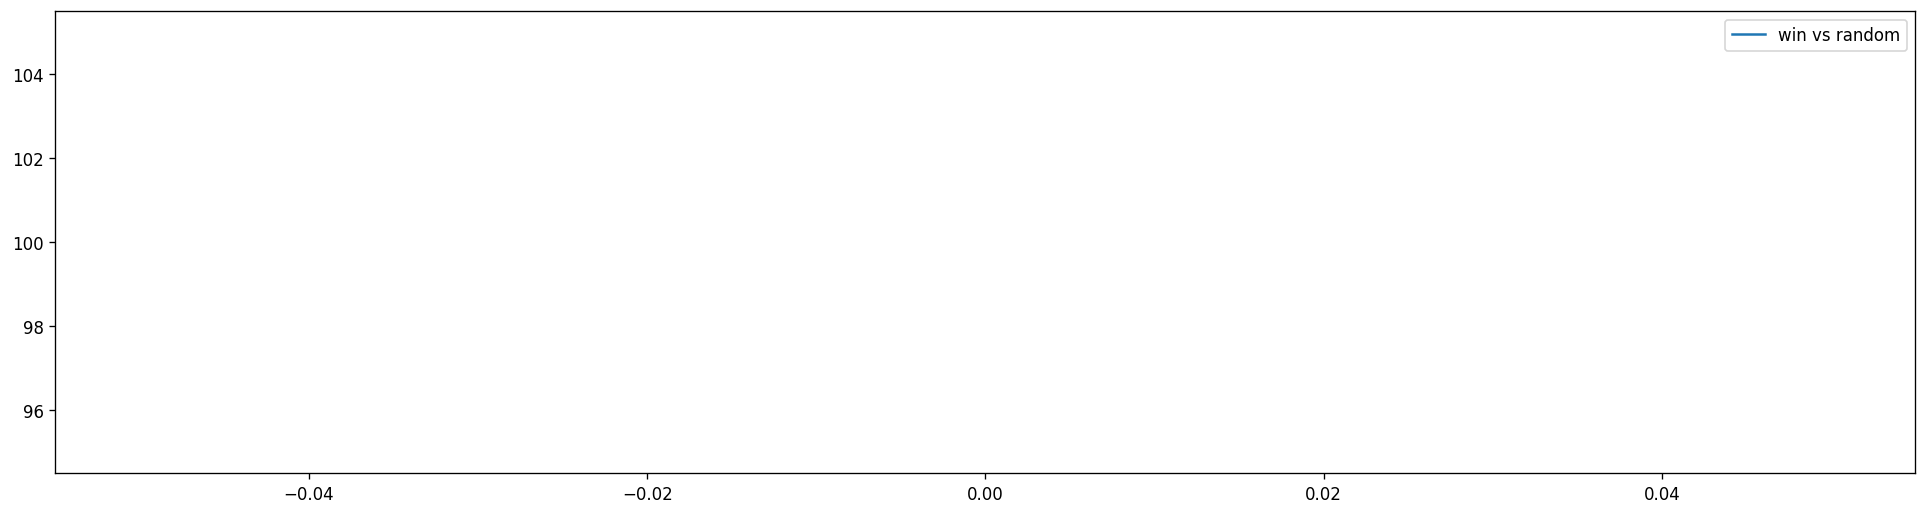

In [7]:
import matplotlib.pyplot as plt

ct = Connect4Trainer(build_model, QLearningAgent, RandomAgent)
model, results = ct.self_play_training(1500, 1500)

X = list(range(len(results["self_play"])))
plt.figure(figsize=(20, 5), dpi=120)
plt.plot(X, results["self_play"], label="self_play")
plt.legend()
plt.show()
plt.figure(figsize=(20, 5), dpi=120)
plt.plot(X, results["turns"], label="turns")
plt.legend()
plt.show()
plt.figure(figsize=(20, 5), dpi=120)
plt.plot(list(range(len(results["random"]))), results["random"], label="win vs random")
plt.legend()
plt.show()

In [8]:
import numpy as np
import random
from tqdm import tqdm

class TrainingEnvironment:
    def __init__(self, build_model_function, num_agents=10, num_epochs=5000, eval_interval=500):
        self.num_agents = num_agents
        self.num_epochs = num_epochs
        self.eval_interval = eval_interval
        self.agents = [QLearningAgent(build_model_function()) for _ in range(self.num_agents)]
        self.performance_metrics = {
            "agent_rewards": {i: [] for i in range(self.num_agents)},
            "evaluation": {i: [] for i in range(self.num_agents)}
        }

    def train(self):
        for epoch in tqdm(range(self.num_epochs)):
            agent1_idx, agent2_idx = random.sample(range(self.num_agents), 2)
            agent1, agent2 = self.agents[agent1_idx], self.agents[agent2_idx]

            state = initialize_board()
            done = False
            current_agent = agent1
            next_agent = agent2
            current_player = 1

            rewards1, rewards2 = 0, 0
            current_turn = 0

            while not done:
                action = current_agent.select_action(state)
                if not action:
                    break
                next_state, reward, done = execute_action(state.copy(), action, current_player, current_turn // 2)

                current_agent, next_agent = next_agent, current_agent
                current_player = 3 - current_player
                state = next_state

                if current_player == 1:
                    rewards1 += reward
                else:
                    rewards2 += reward

                current_turn += 1

            self.performance_metrics["agent_rewards"][agent1_idx].append(rewards1)
            self.performance_metrics["agent_rewards"][agent2_idx].append(rewards2)
            
            if (epoch + 1) % self.eval_interval == 0:
                self.evaluate_agents()

    def evaluate_agents(self):
        random_agent = RandomAgent()
        for idx, agent in enumerate(self.agents):
            win_rate = evaluate_agent(agent, random_agent)
            self.performance_metrics["evaluation"][idx].append(win_rate)
            print(f"Evaluation: Agent {idx} Win Rate {win_rate}")

In [27]:
env = TrainingEnvironment(build_model, num_agents=128, num_epochs=1280000, eval_interval=1e1000)
env.train()

100%|██████████| 1280000/1280000 [44:36<00:00, 478.29it/s] 


In [28]:
import random
from keras.src.engine.sequential import Sequential

class Player:
    def __init__(self, name: str, model: Sequential):
        self.name = name
        self.model = model
    
    def __str__(self) -> str:
        return self.name
    
    def __repr__(self) -> str:
        return self.name

    def __format__(self, __format_spec: str) -> str:
        return format(self.name, __format_spec)

class Tournament:
    def __init__(self, players, match_execution):
        assert len(players) % 2 == 0
        self.players = players
        self.tournament_tree = []
        self.matches_stats = []
        self.match_execution = match_execution
    
    def run(self, randomize=True):
        shuffled_players = self.players.copy()
        if randomize:
            random.shuffle(shuffled_players)
        self.tournament_tree = [shuffled_players]
        
        while len(self.tournament_tree[-1]) > 1:
            next_round_players = []
            current_round = self.tournament_tree[-1]
            
            for i in range(0, len(current_round), 2):
                player1 = current_round[i]
                player2 = current_round[i + 1]
                
                winner, p1_stats, p2_stats = self.match_execution(player1, player2)
                next_round_players.append(winner)
                
                self.matches_stats.extend([p1_stats, p2_stats])
            
            self.tournament_tree.append(next_round_players)
    
    def print_tree(self):
        round_number = 1
        stats_index = 0
        for players in self.tournament_tree:
            print(f"Round {round_number}:")
            for i in range(0, len(players), 2):
                player1 = players[i]
                player2 = players[i + 1] if i + 1 < len(players) else None

                if player2 is not None:
                    score1 = self.matches_stats[stats_index]
                    score2 = self.matches_stats[stats_index + 1]
                    print(f"\t{player1} - {score1} vs {score2} - {player2}")
                    stats_index += 2
                else:
                    print(f"\t{player1}")
            
            round_number += 1
    
    def get_best_player(self):
        return self.tournament_tree[-1][0]

In [29]:
def match_execution(p1, p2):
    return p1, 1, 0

t = Tournament(
    [
        Player("a", 0),
        Player("b", 0),
        Player("c", 0),
        Player("d", 0)
    ],
    match_execution
)
t.run(False)
t.print_tree()

Round 1:
	a - 1 vs 0 - b
	c - 1 vs 0 - d
Round 2:
	a - 1 vs 0 - c
Round 3:
	a


In [30]:
players = [Player(str(i), p.model) for i, p in enumerate(env.agents)]
len(players)

128

In [31]:
def match_execution(player1: Player, player2: Player):
    while True:
        state = initialize_board()
        done = False
        current_agent = QLearningAgent(player1.model)
        next_agent = QLearningAgent(player2.model)
        current_player = 1

        rewards1, rewards2 = 0, 0
        current_turn = 0

        while not done:
            action = current_agent.select_action(state)
            if not action:
                break
            next_state, reward, done = execute_action(state.copy(), action, current_player, current_turn // 2)

            current_agent, next_agent = next_agent, current_agent
            current_player = 3 - current_player
            state = next_state

            if current_player == 1:
                rewards1 += reward
            else:
                rewards2 += reward

            current_turn += 1

        if check_win(state, 1):
            return player1, rewards1, rewards2
        elif check_win(state, 2):
            return player2, rewards1, rewards2
        elif is_board_full(state):
            continue

t = Tournament(players, match_execution)
t.run(False)
t.print_tree()

Round 1:
	0 - 67.33333333333333 vs 5.0 - 1
	2 - 36.666666666666664 vs 75.66666666666666 - 3
	4 - 25.0 vs 91.66666666666666 - 5
	6 - 38.484848484848484 vs 40.675324675324674 - 7
	8 - 36.666666666666664 vs 99.16666666666666 - 9
	10 - 81.38095238095238 vs 21.666666666666668 - 11
	12 - 67.42063492063492 vs 38.41269841269841 - 13
	14 - 16.666666666666668 vs 92.5 - 15
	16 - 15.000000000000002 vs 84.71428571428572 - 17
	18 - 52.33333333333333 vs 21.666666666666668 - 19
	20 - 22.916666666666668 vs 74.27777777777777 - 21
	22 - 36.666666666666664 vs 62.5 - 23
	24 - 5.0 vs 50.666666666666664 - 25
	26 - 65.11111111111111 vs 29.166666666666668 - 27
	28 - 80.0 vs 20.666666666666668 - 29
	30 - 24.0 vs 46.666666666666664 - 31
	32 - 10.0 vs 85.0 - 33
	34 - 24.72222222222222 vs 45.78282828282828 - 35
	36 - 16.857142857142858 vs 37.05555555555556 - 37
	38 - 35.833333333333336 vs 82.13492063492063 - 39
	40 - 6.857142857142858 vs 65.25 - 41
	42 - 86.66666666666666 vs 10.0 - 43
	44 - 29.0 vs 48.047619047619

In [32]:
from IPython.display import clear_output
from time import sleep

agent_best = QLearningAgent(t.get_best_player().model)
agent_best.epsilon = 0

state = initialize_board()
done = False
current_player = 1
current_turn = 0

while not done:
    if current_player == 1:
        action = agent_best.select_action(state)
        state, _, done = execute_action(state, action, current_player, current_turn // 2)
        display_board(state)
    else:
        action = int(input("Entrez une colonne (0-6): "))
        state, _, done = execute_action(state, action, current_player, current_turn // 2)
        clear_output(wait=True)
        sleep(0.5)
    current_player = 3 - current_player
    
    current_turn += 1

clear_output(wait=True)
print(current_turn // 2)
sleep(0.5)
display_board(state)

8
. X . . . . . 
. X . . . . . 
O O . . . . . 
O X O . . . . 
O O O . . X . 
X O X . . X X 


# V2

In [25]:
import numpy as np
import random

env = Connect4()
state_shape = env.board.shape
num_actions = 7

agent = DQN(state_shape, num_actions)

gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
batch_size = 32
memory = []

from tqdm import tqdm

for episode in tqdm(range(100)):
    state = env.reset()
    done = False
    while not done:
        if random.random() < epsilon:
            action = np.random.choice(num_actions)
        else:
            q_values = agent.model.predict(state.reshape(1, *state_shape), verbose=0)
            action = np.argmax(q_values)
        next_state, reward, done = env.step(action, env.turn)
        memory.append((state, action, reward, next_state, done))
        state = next_state

        if len(memory) > batch_size:
            minibatch = random.sample(memory, batch_size)
            states, actions, rewards, next_states, dones = zip(*minibatch)
            states = np.array(states)
            actions = np.array(actions)
            rewards = np.array(rewards)
            next_states = np.array(next_states)
            dones = np.array(dones)

            targets = agent.model.predict(states, verbose=0)
            next_q_values = agent.target_model.predict(next_states, verbose=0).max(axis=1)
            targets[range(batch_size), actions] = rewards + gamma * next_q_values * ~dones

            agent.model.train_on_batch(states, targets)

    if epsilon > 0.1:
        epsilon *= epsilon_decay

    agent.update_target_model()

100%|██████████| 100/100 [03:59<00:00,  2.40s/it]


In [26]:
from IPython.display import clear_output
from time import sleep

def human_play(env, agent, state_shape):
    env.reset()
    done = False
    while not done:
        if env.turn == 1:
            q_values = agent.model.predict(env.board.reshape(1, *state_shape), verbose=0)
            action = np.argmax(q_values)
            _, _, done = env.step(action, 1)
            if done:
                print("Le modèle a gagné!")
                print(env.board)
                break
        else:
            clear_output(wait=True)
            sleep(0.5)
            print(env.board)
            action = int(input("Votre tour! Choisissez une colonne (0-6): "))
            _, _, done = env.step(action, -1)
            if done:
                print("Vous avez gagné!")
                print(env.board)
                break

human_play(env, agent, state_shape)

[[ 1  0  0  0  0  0  1]
 [-1  0  0  0  0  0  1]
 [-1  0  0  0  0  0  1]
 [ 1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]]
Le modèle a gagné!
[[ 1 -1  0  0  0  0  1]
 [-1  0  0  0  0  0  1]
 [-1  0  0  0  0  0  1]
 [ 1  0  0  0  0  0  1]
 [-1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]]


In [ ]:
agent.save()